# Notebook for analyze the gene set similarity with hypergeometric test

In [2]:
%run hypergeometric_GO.py --input_file data/GO_term_analysis/simrank_LLM_processed_selected_1000_go_terms.tsv --topn 3 --output_file data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv

100%|██████████| 1000/1000 [00:05<00:00, 170.64it/s]


In [3]:
import pandas as pd 
df = pd.read_csv('data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t')

In [4]:
best_term_q = df['adj_pvals'].str.split('|').apply(lambda x: float(x[0]))

best_term_q.describe()

count     1.000000e+03
mean      2.288606e-01
std       4.061747e-01
min      2.846574e-258
25%       5.482669e-15
50%       3.740306e-05
75%       1.308999e-01
max       1.000000e+00
Name: adj_pvals, dtype: float64

In [6]:
df['random_adj_pvals'].apply(lambda x: float(x)).describe()

count    1.000000e+03
mean     9.350001e-01
std      2.220187e-01
min      1.437986e-88
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: random_adj_pvals, dtype: float64

974
974 974
Median of top1_q_log:  4.647558643515264 raw:  2.2514511002206778e-05
Median of random_q_log:  -4.342945178152237e-11 raw:  1.0
0.9999999995657055
p-value of Mann-Whitney U test:  3.1736034117009394e-245


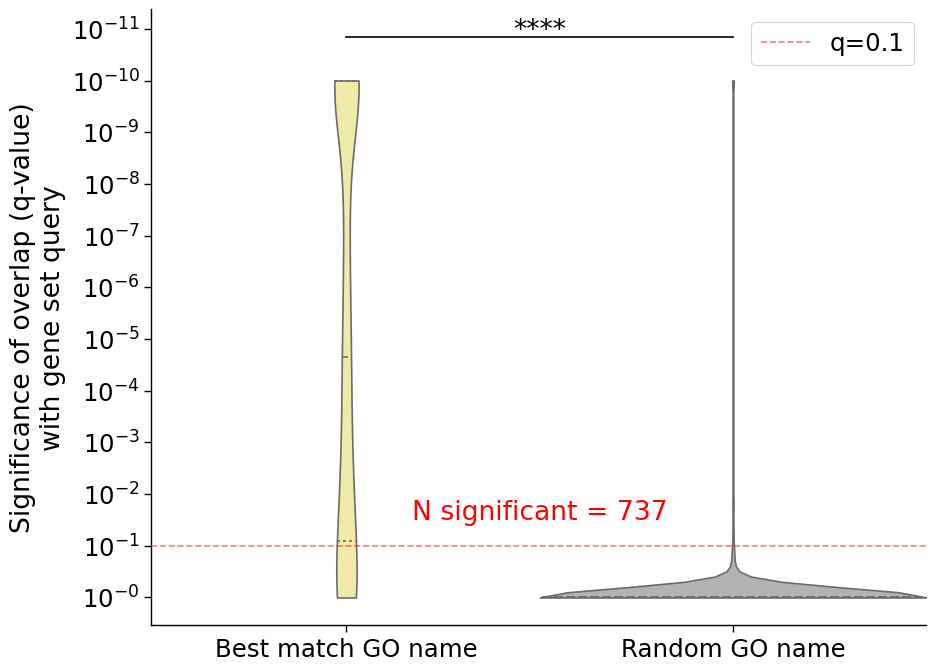

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import mannwhitneyu
from matplotlib.ticker import FuncFormatter, MultipleLocator

cutoff = 0.1

# I need to remove rows that names are 'System of unrelated proteins'
df = df[df['gpt_4_default Name'] != 'System of unrelated proteins']
print(len(df))

top1_q = df['adj_pvals'].str.split('|').apply(lambda x: float(x[0]))
random_q = df['random_adj_pvals'].apply(lambda x: float(x))

# -log signifiance
# calculate -log(q)
eps = 1e-10
top1_q_log = -np.log10(top1_q+eps)
random_q_log = -np.log10(random_q+eps)
print(len(top1_q_log), len(random_q_log))
print('Median of top1_q_log: ', top1_q_log.median(), 'raw: ', top1_q.median())
print('Median of random_q_log: ', random_q_log.median(), 'raw: ', random_q.median())
significant = -np.log10(cutoff+eps)
print(significant)

sns.set_context("paper", font_scale=2)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["axes.unicode_minus"] = True

fig, ax = plt.subplots(figsize=(10, 8))

# add statistical test 

diff_p = mannwhitneyu(top1_q_log, random_q_log)[1]
print('p-value of Mann-Whitney U test: ', diff_p)

sns.violinplot(data=[top1_q_log, random_q_log], ax=ax, palette=['#FBF49C', '#B3B3B3'], inner='quartile', cut=0, split=True, width=1)



def format_func(value, tick_number):
    if value >= 0:
        return f'$10^{{-{int(value)}}}$'
    else:
        return f'$10^{{{-int(value)}}}$'

ax.yaxis.set_major_formatter(FuncFormatter(format_func))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.set_ylabel("Significance of overlap (q-value)\nwith gene set query")

ax.axhline(significant, ls='--', color='red', alpha=0.5, label=f'q={cutoff}')
ax.legend(loc='upper right')
ax.set_xticklabels(["Best match GO name", "Random GO name"])
# Get the current x-limits
x_min, x_max = ax.get_xlim()

# Set new x-limits with more space on the left
ax.set_xlim(x_min - 0.005, x_max)

# Calculate the number of significant best match GOs
n_significant = (top1_q < cutoff).sum()

# Add text above the line showing the number of significant best match GOs
ax.text(0.5, significant + 0.5, f'N significant = {n_significant}', color='red', ha='center')

# add significance bar

max_y = max(max(top1_q_log), max(random_q_log))+0.03  # find the maximum y value with some gap
bar_height = max_y * 0.08  # set height of the bar to be 8% of the maximum y value
bar_start = 0 
bar_end = 1 

plt.plot([bar_start, bar_end], [max_y + bar_height, max_y + bar_height], color='black')  # plot horizontal line
# plt.plot([bar_start, bar_start], [max_y, max_y + bar_height], color='black')  # plot vertical line at start of the bar
# plt.plot([bar_end, bar_end], [max_y, max_y + bar_height], color='black')  # plot vertical line at end of the bar

# add asterisks or other text to indicate the level of significance
if diff_p < 0.0001:
    plt.text((bar_start + bar_end) / 2, max_y + bar_height, "****", ha='center')
elif diff_p < 0.001:
    plt.text((bar_start + bar_end) / 2, max_y + bar_height, "***", ha='center')
elif diff_p < 0.01:
    plt.text((bar_start + bar_end) / 2, max_y + bar_height, "**", ha='center')
elif diff_p < 0.05:
    plt.text((bar_start + bar_end) / 2, max_y + bar_height, "*", ha='center')
else:
    plt.text((bar_start + bar_end) / 2, max_y + bar_height, "ns", ha='center')


sns.despine()

plt.savefig("figures/LLM_name_GO_term_bestmatch_logq_violin_cutoff01.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [10]:
top1_q_log.min()

-4.342945178152237e-11

In [11]:
top1_q_log.max()

10.0

In [4]:
import numpy as np
import pandas as pd


cutoff = 0.1

df = pd.read_csv('data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t')

# df.head()

# initialize an empty dictionary to store results
results = {}

# iterate over the rows of your dataframe
for i, row in df.iterrows():
    # get the adjusted p-values for this row
    adj_pvals = np.array([float(pval) for pval in row['adj_pvals'].split('|')])
    
    # for each N from 1 to 50
    for N in range(1, 51):
        # take the first N adjusted p-values
        top_pvals = adj_pvals[:N]
        
        # count the number of p-values less than cutoff
        significant = int(any(top_pvals < cutoff))
        
        # compute the proportion and store in the dictionary
        results.setdefault(N, []).append(significant)

# convert the dictionary to a dataframe
results_df = pd.DataFrame(results, index=df['GO'])

# results_df.head()
# count the number of rows with at least one significant p-value for each N
counts = results_df.apply(lambda x: (x == 1).sum())

# convert the series to a dataframe and reset the index
counts_df = counts.reset_index()
counts_df.columns = ['N', 'Count']
# add N = 0, Count = 0 to the dataframe
counts_df = pd.concat([pd.DataFrame({'N': [0], 'Count': [0]}), counts_df])
counts_df.reset_index(drop=True, inplace=True)
counts_df.head()

,N,Count
0,0,0
1,1,862
2,2,929
3,3,956
4,4,968


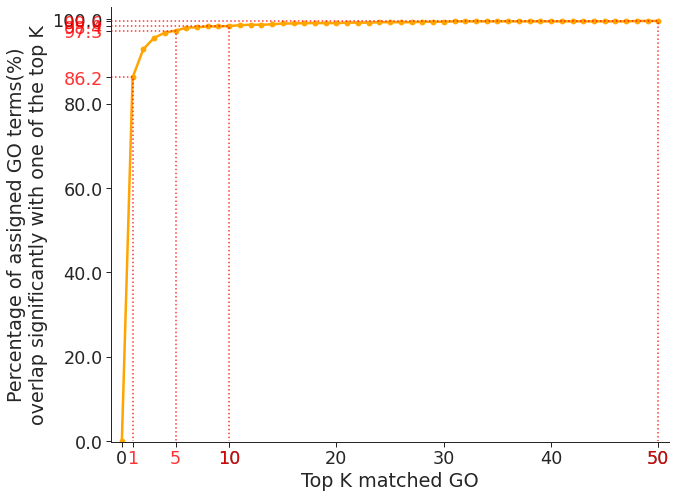

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("paper", font_scale=2)
plt.rcParams['pdf.fonttype'] = 42
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(10, 8))
counts_df = counts_df
# plot the proportion of significant p-values for each N
ax.plot(counts_df['N'], 100*(counts_df['Count']/len(df)), color='orange', marker='o',linewidth=2.5)

for N in [1, 5, 10, 50]:
    counts = (counts_df[counts_df['N'] == N]['Count'].values[0]/len(df))*100

    ax.plot([-1, N, N], [counts, counts, 0], color='red', linestyle=':', alpha= 0.8,linewidth=1.5, label=f'K = {N}, {counts}% GO terms enriched')
        # Set ticks on the x-axis and y-axis
    ax.set_xticks(list(ax.get_xticks()) + [N])
    ax.set_yticks(list(ax.get_yticks()) + [counts] )

    # Get the tick labels
    xticklabels = ax.get_xticklabels()
    yticklabels = ax.get_yticklabels()


    # Modify specific tick label color on x-axis
    xticklabels[-1].set_color('red')
    xticklabels[-1].set_alpha(0.8)

    # Modify specific tick label color on y-axis
    yticklabels[-1].set_color('red')
    yticklabels[-1].set_alpha(0.8)

# ax.legend(loc='upper right', fontsize=16, bbox_to_anchor=(0.95, 0.95))
sns.despine()
ax.set_ylim(-0.08, 103)
ax.set_xlim(-1, 51)
ax.set_xlabel('Top K matched GO')
ax.set_ylabel('Percentage of assigned GO terms(%)\noverlap significantly with one of the top K')
plt.savefig("figures/LLM_name_GO_term_bestmatch_significant_top50.pdf", dpi=300, bbox_inches='tight')
plt.show()

## calculate the exact overlap 
in the 500 GO names that are not semantically similar GPT 4 name

Calculate if the best matching name is associated to a term that is more general concept

In [20]:
from tqdm import tqdm
import  pandas as pd
import numpy as np


def genes_coverage(genes, all_genes):
    return len(set(genes).intersection(set(all_genes))) / len(genes)

df = pd.read_csv('data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t')
df.set_index('GO', inplace=True)
all_go = pd.read_csv('data/go_terms.csv', index_col=0)

# filter the list by ranking the percentile and keep only the bottom 500
df_sorted = df.sort_values(by='true_GO_term_sim_percentile', ascending=True)
df_filtered = df_sorted.iloc[0:500]
# for the bottom 500, how many have name 'System of unrelated proteins', remove
# because System of unrelated proteins will not have a best name that covers>50% of the genes
df_filtered = df_filtered[df_filtered['gpt_4_default Name']!= 'System of unrelated proteins']
print(df_filtered.shape)
new_df = df_filtered.loc[:,['Genes', 'Gene_Count', 'Term_Description','gpt_4_default Name',
       'gpt_4_default Analysis', 'gpt_4_default Score', 'top_3_hits']]

new_df['covered_by_best_match'] = False

genes_coverage_list = []
genes_overlap_list = []
for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
    current_gene_set = row['Genes'].split(' ')
    top_n_hits = row[f'top_3_hits'].split('|')
    top_match = top_n_hits[0]
    genes = all_go[all_go['Term_Description'] == top_match]['Genes'].tolist()[0].split(' ')
    
    if len(genes)>len(current_gene_set):
        coverage = genes_coverage(current_gene_set, genes)
        genes_coverage_list.append(coverage)
    else:
        coverage = genes_coverage(current_gene_set, genes)
        genes_overlap_list.append(coverage)
    if coverage > 0.5:
        new_df.loc[i, 'covered_by_best_match'] = True

# check how many are giving a general term coverage >50%, how many are giving a specific term coverage >50%
print(len(genes_coverage_list), len(genes_overlap_list))
high_coverage = np.sum(np.array(genes_coverage_list)>=0.5)
high_overlap = np.sum(np.array(genes_overlap_list)>=0.5)
print(f'Coverage >50%: {high_coverage}')
print(f'Overlap >50%: {high_overlap}')   
print(f'Coverage >50%: {(high_coverage/len(new_df))*100}%')
print(f'Overlap >50%: {(high_overlap/len(new_df))*100}%')


(474, 21)


100%|██████████| 474/474 [00:00<00:00, 1118.20it/s]

408 66
Coverage >50%: 180
Overlap >50%: 1
Coverage >50%: 37.9746835443038%
Overlap >50%: 0.21097046413502107%


<Axes: ylabel='gpt_4_default Score'>

/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 43.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


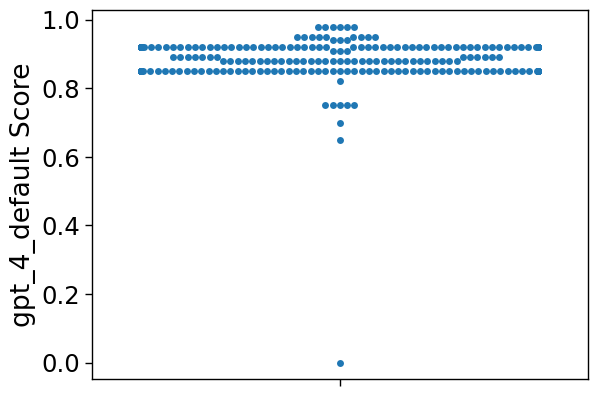

In [23]:
# check the confidence score of the bottom 500 that have coverage <50%
filter_new= new_df[new_df['covered_by_best_match']==False]
sns.swarmplot(data=filter_new, y = 'gpt_4_default Score')


In [29]:
filter_new.loc[filter_new['gpt_4_default Score']>0.87].shape    

(169, 8)

In [ ]:
# pick 25 from the bottom that have top hit term coverage <50%

